In [150]:
import networkx as nx
import matplotlib.pyplot as plt

In [151]:
#All from other notebook
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram, plot_bloch_multivector

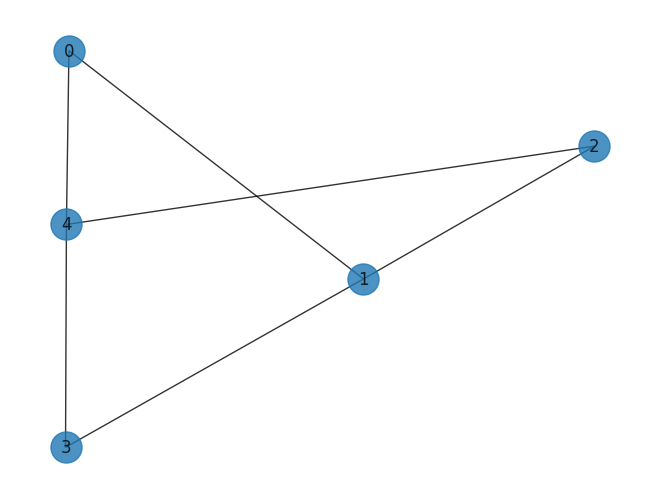

In [152]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (0, 4), (2, 1), (2,4), (3, 1), (3,4)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

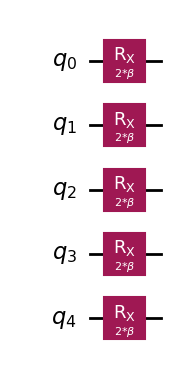

In [160]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = len(G.nodes)

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw('mpl')

(0, 1)
(0, 4)
(1, 2)
(1, 3)
(2, 4)
(3, 4)


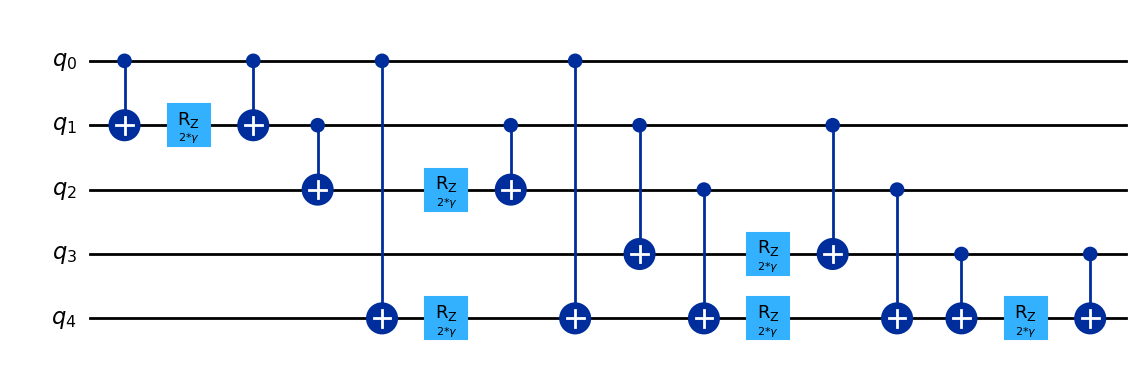

In [167]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    print(pair)
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    
qc_p.decompose().draw('mpl')


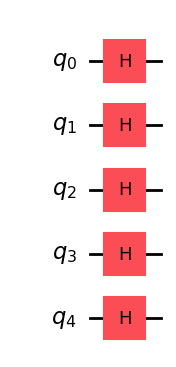

In [168]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw('mpl')

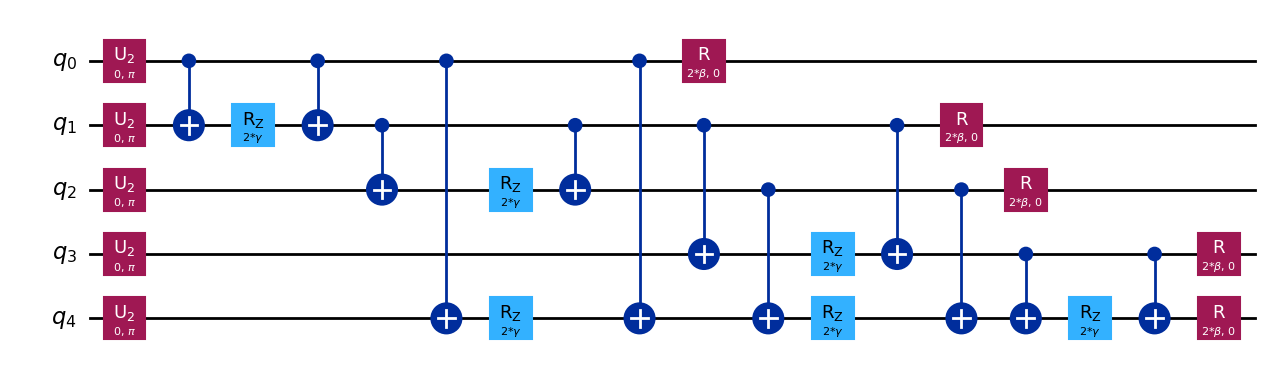

In [169]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw('mpl')

In [170]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

Bet = []
Gam = []
# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    #print('theta: ', theta)
    #print('p: ', p)
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    #extra start
    print('beta: ', beta)
    print('gamma: ', gamma)
    Bet.append(beta)
    Gam.append(gamma)
    ##extra done
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = AerSimulator().run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=512):
    
    """
    Runs parametrized circuit
    """
    
#    backend = Aer.get_backend('aer_simulator')
    AerSimulator.shots = shots
    
   
    
    return execute_circ

beta:  [1.]
gamma:  [1.]
beta:  [2.]
gamma:  [1.]
beta:  [2.]
gamma:  [2.]
beta:  [2.7026527]
gamma:  [0.28846702]
beta:  [3.36957103]
gamma:  [-0.45666381]
beta:  [3.02676772]
gamma:  [0.66918929]
beta:  [2.27995307]
gamma:  [0.02139956]
beta:  [2.8689128]
gamma:  [0.10176517]
beta:  [2.709027]
gamma:  [0.41330438]
beta:  [2.64660832]
gamma:  [0.41649153]
beta:  [2.83400325]
gamma:  [0.4108676]
beta:  [2.64702829]
gamma:  [0.42120436]
beta:  [2.7402696]
gamma:  [0.41262436]
beta:  [2.74060961]
gamma:  [0.42824566]
beta:  [2.74174074]
gamma:  [0.38140901]
beta:  [2.7445332]
gamma:  [0.35028402]
beta:  [2.77577861]
gamma:  [0.34974836]
beta:  [2.8038549]
gamma:  [0.33602669]
beta:  [2.77704357]
gamma:  [0.36532207]
beta:  [2.7800093]
gamma:  [0.34318053]
beta:  [2.77945265]
gamma:  [0.33538788]
beta:  [2.78743242]
gamma:  [0.34561616]
beta:  [2.77699406]
gamma:  [0.34069715]
beta:  [2.77433666]
gamma:  [0.33783411]
beta:  [2.77823575]
gamma:  [0.33918953]
beta:  [2.77318655]
gamma:  [0.

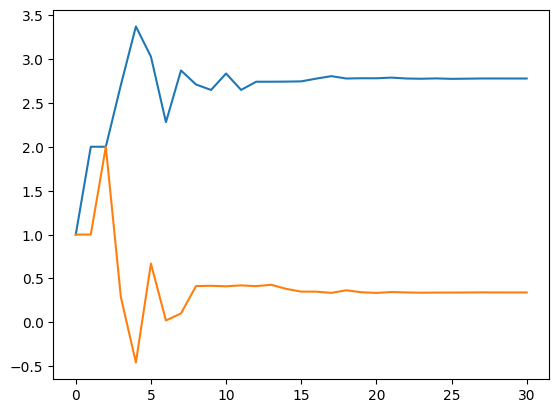

In [171]:
from scipy.optimize import minimize


expectation = get_expectation(G)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')                  
res 

Tim = range(len(Bet))
plt.plot(Tim, Bet)
plt.plot(Tim, Gam)
plt.show()

beta:  [2.77699406]
gamma:  [0.34069715]


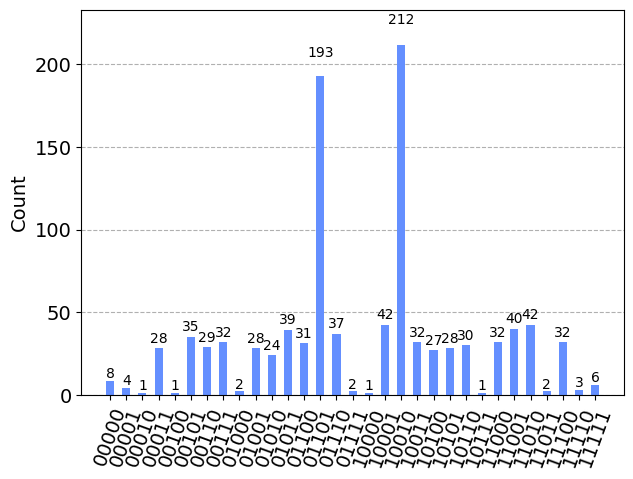

In [172]:
from qiskit.visualization import plot_histogram

AerSimulator.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = AerSimulator().run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)